# 0.引入所需模組與必要的資料集

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV

In [3]:
from sklearn.ensemble import ExtraTreesClassifier

In [4]:
# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [5]:
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(font_scale=1.56)

In [6]:
df_test = pd.read_csv('../../data/kaggle_titanic/test.csv')
df_train = pd.read_csv('../../data/kaggle_titanic/train.csv')
df_data = df_train.append(df_test)

# 1.查看資料

探索性分析EDA:  
模型考慮：抗噪強的(svm,knn,隨機森林)  
廣泛性：對小資料集來說三個都可以，但隨機森林可以平行化  
預處理：svm,knn分別超平面跟鄰近投票，但不如隨機森林用gini不純度簡便  

In [ ]:
def DatasetsInfo(train_data,test_data):
    df_train.info()
    print("-" * 40)
    df_test.info()
DatasetsInfo(df_train,df_test)

In [ ]:
print(df_train.describe())
print("-" * 40)
print(df_train.describe(include=['O']))

In [ ]:
def DatasetMissingPercentage(data):
    return pd.DataFrame({'DataMissingPercentage':data.isnull().sum() * 100 / len(df_train)})

DatasetMissingPercentage(df_train)

In [ ]:
DatasetMissingPercentage(df_test)

In [ ]:
def DatasetUniquePercentage(data):
    return pd.DataFrame({'percent_unique':data.apply(lambda x: x.unique().size/x.size*100)})

DatasetUniquePercentage(df_train)

In [ ]:
DatasetUniquePercentage(df_test)

# 2.分析資料

## 基礎分析

In [37]:
def checkDatasetNan(data):
    print('Id is unique.') if data.PassengerId.nunique() == data.shape[0] else print('oops')
    print('Train and test sets are distinct.') if len(np.intersect1d(data.PassengerId.values, df_test.PassengerId.values))== 0 else print('oops')#0表示train,test dataset資料一致
    #查看資料是否有nan並設置datasetHasNan flag   
    if data.count().min() == data.shape[0] and df_testset.count().min() == df_testset.shape[0] :
        print('We do not need to worry about missing values.') 
    else:
        nas = pd.concat([data.isnull().sum(), df_test.isnull().sum()], axis=1, keys=['Train Dataset', 'Test Dataset']) 
        print('Nan in the data sets')
        print(nas[nas.sum(axis=1) > 0])
checkDatasetNan(df_train)

Id is unique.
Train and test sets are distinct.
Nan in the data sets
          Train Dataset  Test Dataset
Age                 177            86
Cabin               687           327
Survived              0           418


## 相關性分析

In [ ]:
# Sex vs Survived
print(df_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()
# Class vs Survived，存活率高到低，P1,P2,P3  
print(df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()
# Sex and Class vs Survived
print(df_train[['Sex', 'Pclass', 'Survived']].groupby(['Sex', 'Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()
# SibSp vs Survived
print(df_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()
# Parch vs Survived
print(df_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()
# Family vs Survived
df_train['Family'] = df_train['SibSp'] + df_train['Parch']
print(df_train[['Family', 'Survived']].groupby(['Family'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()
# Embark vs Survived
print(df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print()

1.大部分男生都死了，大部分女生活下來  
2.階級跟存活率成正比
3.最低艙等女性存活率還是比最高艙等男性高  
4.旁系血親1個存活率最高   
5.直系血親3個存活率最高  
6.如果加總，有3個親友存活率高  
7.船艙存活率C>Q>S  

In [ ]:
def FeatureCorreate(datasets,dropData):
    sns.set(context="paper", font="monospace")
    sns.set(style="white")
    f, ax = plt.subplots(figsize=(10,6))
    train_corr = datasets.drop(dropData,axis=1).corr()
    sns.heatmap(train_corr, ax=ax, vmax=.9, square=True)
    ax.set_xticklabels(train_corr.index, size=15)
    ax.set_yticklabels(train_corr.columns[::-1], size=15)
    ax.set_title('Feature Corr', fontsize=20)
print("Train Features")
FeatureCorreate(df_train,'PassengerId')

# 3.特徵工程

## fare,sex處理 問題：要怎麼切區間，切幾分比較好？5  

In [7]:
#轉換性別文字為數字
df_data['Sex_Code'] = df_data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')

In [8]:
#再把訓練與測試集分開
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

In [9]:
#定義預測與預測結果資料集
Y = df_train['Survived']
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)

In [ ]:
#再把訓練與測試集分開
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

In [10]:
#定義預測與預測結果資料集
Y = df_train['Survived']
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)

In [11]:
#基準模型，比他低可能加入太多噪聲的特徵，或過擬合了  
Base = ['Sex_Code','Pclass']
Base_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score :%.5f' %(Base_Model.oob_score_))

Base oob score :0.73176


In [12]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Sex_Code       1309 non-null int64
dtypes: float64(3), int64(5), object(5)
memory usage: 143.2+ KB


Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

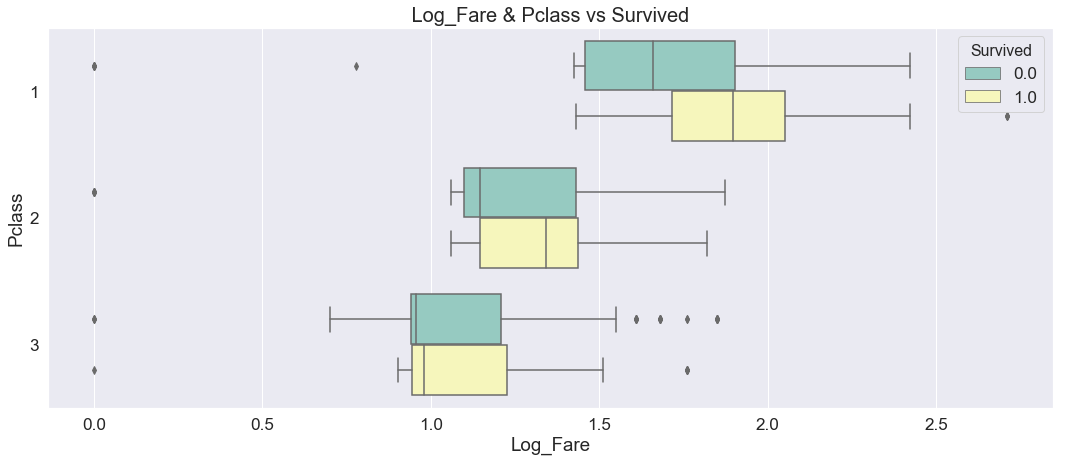

In [13]:
# there is some bugs in log-scale of boxplot. 
# alternatively, we transform x into log10(x) for visualization.
fig, ax = plt.subplots( figsize = (18,7) )
df_data['Log_Fare'] = (df_data['Fare']+1).map(lambda x : np.log10(x) if x > 0 else 0)
sns.boxplot(y='Pclass', x='Log_Fare',hue='Survived',data=df_data, orient='h'
                ,ax=ax,palette="Set3")
ax.set_title(' Log_Fare & Pclass vs Survived ',fontsize = 20)
pd.pivot_table(df_data,values = ['Fare'], index = ['Pclass'], columns= ['Survived'] ,aggfunc = 'median' ).round(3)

Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


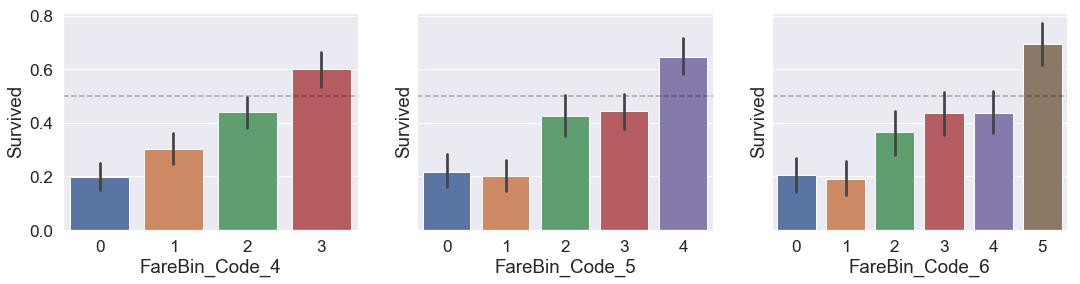

In [14]:
#只有一個缺失，填中位數就可以了，還要適當切分票價避免過擬合
# Filling missing values
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())

# 用pandas qcut以累積百分比來切分
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)

label = LabelEncoder()
df_data['FareBin_Code_4'] = label.fit_transform(df_data['FareBin_4'])
df_data['FareBin_Code_5'] = label.fit_transform(df_data['FareBin_5'])
df_data['FareBin_Code_6'] = label.fit_transform(df_data['FareBin_6'])

# cross tab
df_4 = pd.crosstab(df_data['FareBin_Code_4'],df_data['Pclass'])
df_5 = pd.crosstab(df_data['FareBin_Code_5'],df_data['Pclass'])
df_6 = pd.crosstab(df_data['FareBin_Code_6'],df_data['Pclass'])

display_side_by_side(df_4,df_5,df_6)

# plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3,sharey=True)
fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5,linestyle='dashed', c='black',alpha = .3)
g1 = sns.factorplot(x='FareBin_Code_4', y="Survived", data=df_data,kind='bar',ax=ax1)
g2 = sns.factorplot(x='FareBin_Code_5', y="Survived", data=df_data,kind='bar',ax=ax2)
g3 = sns.factorplot(x='FareBin_Code_6', y="Survived", data=df_data,kind='bar',ax=ax3)
# close FacetGrid object
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)

In [15]:
# fare切割完再分一次訓練與測試集
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']
# show columns
X.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Ticket', 'Sex_Code', 'Log_Fare', 'FareBin_4', 'FareBin_5',
       'FareBin_6', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6'],
      dtype='object')

In [16]:
#RFE選擇特徵，跟Chi square、或是information gain比可以考慮到特徵之間的交互作用
compare = ['Sex_Code','Pclass','FareBin_Code_4','FareBin_Code_5','FareBin_Code_6']
selector = RFECV(RandomForestClassifier(n_estimators=250,min_samples_split=20),cv=10,n_jobs=-1)
selector.fit(X[compare], Y)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_*100)
#看來切6份比較好，但還要驗證

[ True  True  True  True  True]
[1 1 1 1 1]
[78.66981614 77.33398593 79.0144138  79.13057542 80.36655885]


In [17]:
score_b4,score_b5, score_b6 = [], [], []
seeds = 10
for i in range(seeds):
    diff_cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
    selector = RFECV(RandomForestClassifier(random_state=i,n_estimators=250,min_samples_split=20),cv=diff_cv,n_jobs=-1)
    selector.fit(X[compare], Y)
    score_b4.append(selector.grid_scores_[2])
    score_b5.append(selector.grid_scores_[3])
    score_b6.append(selector.grid_scores_[4])

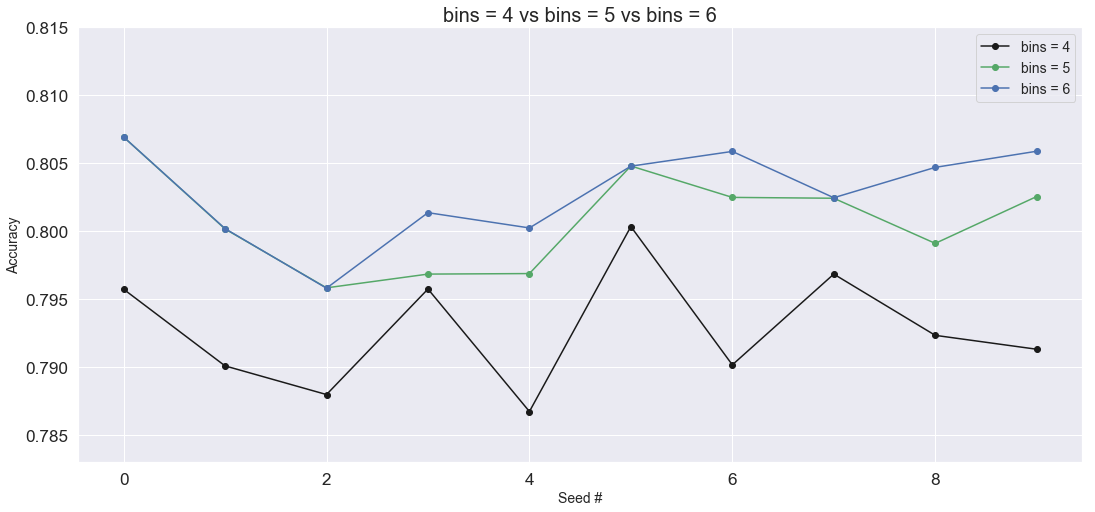

In [18]:
# to np.array
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
    item = np.array(item*100)
# plot
fig = plt.figure(figsize= (18,8) )
ax = plt.gca()
ax.plot(range(seeds), score_b4,'-ok',label='bins = 4')
ax.plot(range(seeds), score_b5,'-og',label='bins = 5')
ax.plot(range(seeds), score_b6,'-ob',label='bins = 6')
ax.set_xlabel("Seed #", fontsize = '14')
ax.set_ylim(0.783,0.815)
ax.set_ylabel("Accuracy", fontsize = '14')
ax.set_title('bins = 4 vs bins = 5 vs bins = 6', fontsize='20')
plt.legend(fontsize = 14,loc='upper right')

In [19]:
b4, b5, b6 = ['Sex_Code', 'Pclass','FareBin_Code_4'], ['Sex_Code','Pclass','FareBin_Code_5'],\
['Sex_Code','Pclass','FareBin_Code_6']
b4_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b4_Model.fit(X[b4], Y)
b5_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b5_Model.fit(X[b5], Y)
b6_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
b6_Model.fit(X[b6], Y)
print('b4 oob score :%.5f' %(b4_Model.oob_score_),'   LB_Public : 0.7790')
print('b5 oob score :%.5f '%(b5_Model.oob_score_),' LB_Public : 0.79425')
print('b6 oob score : %.5f' %(b6_Model.oob_score_), '  LB_Public : 0.77033')

b4 oob score :0.80584    LB_Public : 0.7790
b5 oob score :0.81033   LB_Public : 0.79425
b6 oob score : 0.80135   LB_Public : 0.77033


oob顯示切五份比較好，確定切五份

## ticket處理 問題：持有相同票那群人的關係 

In [20]:
df_train['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

有人有相同車票，可能是家人朋友    

In [21]:
# Family_size
df_data['Family_size'] = df_data['SibSp'] + df_data['Parch'] + 1

In [22]:
#觀察相同票根‘那些人的姓名、票價、艙位、家庭人數  
deplicate_ticket = []
for tk in df_data.Ticket.unique():
    tem = df_data.loc[df_data.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


## age跟title，還有family_size 問題：

可以從票跟姓名看出那天上船情況，接下來Family_size 分類，1朋友，>1家人  

In [23]:
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri,df_fami)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size > 1]))

,Name,Ticket,Fare,Cabin,Family_size,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1.0
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1.0


,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


people keep the same ticket: 596 
friends: 127 
families: 469 


1.過濾出重複的票根 : if( len(df_grp) > 1)  
2.如果群組中有人生還 則定義 Connected_Survival = 1 : if(smax == 1.0):  
3.沒有人生還，則定義Connected_Survival = 0 : if( smin == 0.0):  
4.剩下的沒有生還資訊，定義Connected_Survival = 0.5 : 程式碼第一行 df_data['Connected_Survival'] = 0.5  

In [24]:
# the same ticket family or friends
df_data['Connected_Survival'] = 0.5 # default 
for _, df_grp in df_data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(df_data[df_data['Connected_Survival']!=0.5].shape[0]))
df_data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


connected information連結關係(0 or 1 )

In [25]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 22 columns):
Age                   1046 non-null float64
Cabin                 295 non-null object
Embarked              1307 non-null object
Fare                  1309 non-null float64
Name                  1309 non-null object
Parch                 1309 non-null int64
PassengerId           1309 non-null int64
Pclass                1309 non-null int64
Sex                   1309 non-null object
SibSp                 1309 non-null int64
Survived              891 non-null float64
Ticket                1309 non-null object
Sex_Code              1309 non-null int64
Log_Fare              1309 non-null float64
FareBin_4             1309 non-null category
FareBin_5             1309 non-null category
FareBin_6             1309 non-null category
FareBin_Code_4        1309 non-null int64
FareBin_Code_5        1309 non-null int64
FareBin_Code_6        1309 non-null int64
Family_size           1309 non-nul

In [26]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [27]:
connect = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival']
connect_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20
                                       ,oob_score=True)
connect_Model.fit(X[connect], Y)
print('connect oob score :%.5f' %(connect_Model.oob_score_))

connect oob score :0.82043


age缺1309-1046=263個值，缺的不少，不能直接用平均值填    

Sex,female,male,All
Has_Age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


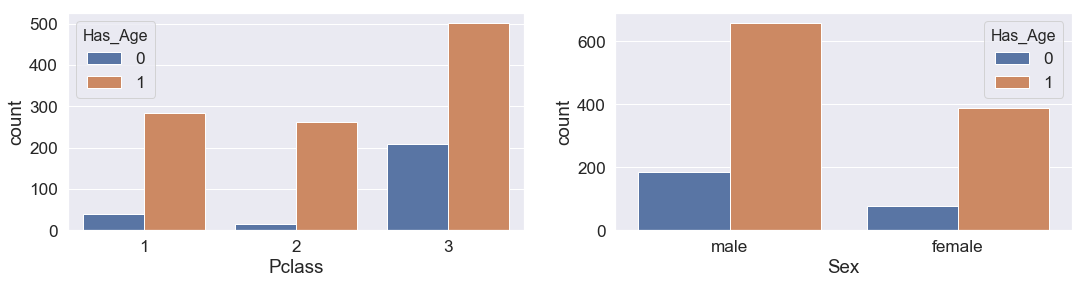

In [28]:
#觀察年齡缺失
df_data['Has_Age'] = df_data['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
ax1 = sns.countplot(df_data['Pclass'],hue=df_data['Has_Age'],ax=ax1)
ax2 = sns.countplot(df_data['Sex'],hue=df_data['Has_Age'],ax=ax2)
pd.crosstab(df_data['Has_Age'],df_data['Sex'],margins=True).round(3)

左：PClass3缺失值最多，如果也觀察就會失真，所以只看PClass1,2 右：男性缺失值較多，另外還需要知道年齡跟生存率關係  
所以接下來觀察PClass1,2年齡跟生存率關係  

Text(0.5, 1.0, 'Age vs Survived in Pclass = 1 and  2')

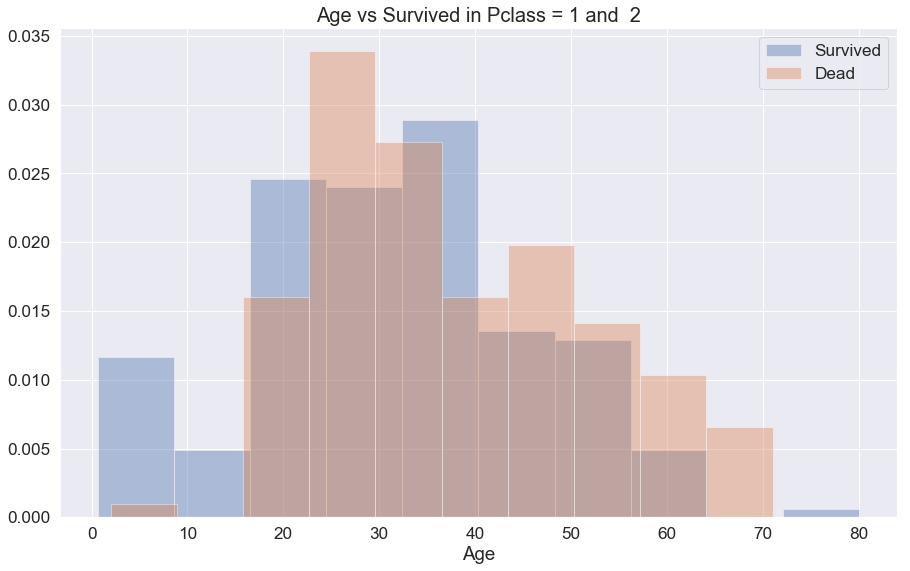

In [29]:
# Masks
Mask_Has_Age_P12_Survived = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 1) )
Mask_Has_Age_P12_Dead = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 0) )
# Plot
fig, ax = plt.subplots( figsize = (15,9) )
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Survived, 'Age'],kde=False,bins=10,norm_hist=True,label='Survived') 
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Dead, 'Age'],kde=False,bins=10,norm_hist=True,label='Dead')
ax.legend()
ax.set_title('Age vs Survived in Pclass = 1 and  2',fontsize = 20)

1.小孩<16生存率高  
2.>16年齡不算顯著特徵
3.70-80樣本數太少   
4.找出那些<16歲的缺失值填補(用姓名當中的稱謂中位數來填補)是重要的，這會影響預測，而>16歲的部分則不採用，否則只是擬合了噪聲，因此年齡這個特徵可以抽取出<16歲及>16歲做為一個2元特徵  

In [30]:
# 用title做特徵值分類
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'],'Mrs')
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })
Ti = df_data.groupby('Title')['Age'].median()
Ti

Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64

不動原始特徵Age，將填滿年齡的特徵創建為Ti_Age，分為<16歲及>16歲，命名為Ti_Minor

In [31]:
Ti_pred = df_data.groupby('Title')['Age'].median().values
df_data['Ti_Age'] = df_data['Age']
# Filling the missing age
for i in range(0,5):
 # 0 1 2 3 4 5
    df_data.loc[(df_data.Age.isnull()) & (df_data.Title == i),'Ti_Age'] = Ti_pred[i]
df_data['Ti_Age'] = df_data['Ti_Age'].astype('int')
df_data['Ti_Minor'] = ((df_data['Ti_Age']) < 16.0) * 1

In [32]:
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [33]:
minor = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival','Ti_Minor']
minor_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
minor_Model.fit(X[minor], Y)
print('minor oob score :%.5f' %(minor_Model.oob_score_))

minor oob score :0.84175


## embarked處理 問題：填補兩個空值

In [35]:
df_data[df_data['Embarked'].isnull()]#fare都是80,Pclass是1

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,FareBin_6,FareBin_Code_4,FareBin_Code_5,FareBin_Code_6,Family_size,Connected_Survival,Has_Age,Title,Ti_Age,Ti_Minor
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,...,"(53.1, 512.329]",3,4,5,1,1.0,1,3,38,0
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,...,"(53.1, 512.329]",3,4,5,1,1.0,1,4,62,0


Id is unique.
oops
Nan in the data sets
          Train Dataset  Test Dataset
Age                 263            86
Cabin              1014           327
Survived            418           418


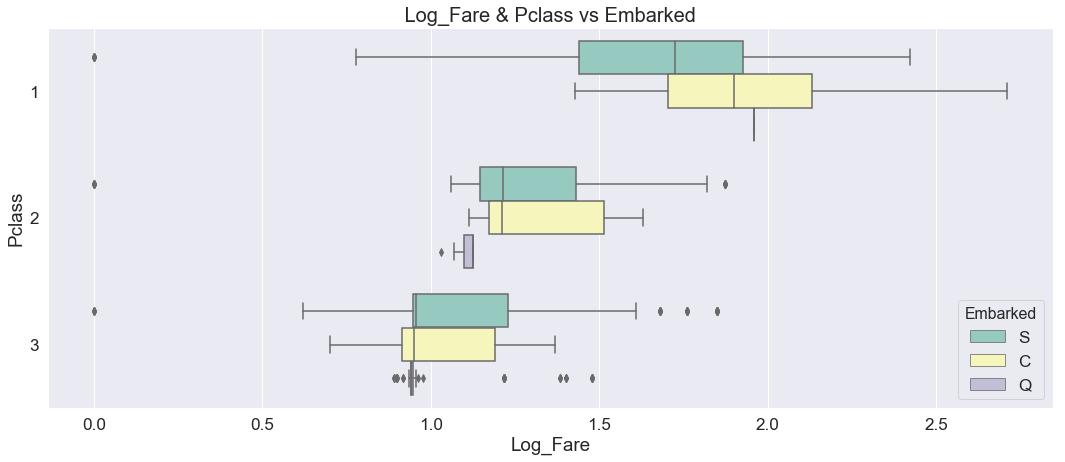

In [38]:
#fare,pclass,跟Embarked的箱线图，看起來缺失值是c
fig, ax = plt.subplots( figsize = (18,7) )
df_data['Log_Fare'] = (df_data['Fare']+1).map(lambda x : np.log10(x) if x > 0 else 0)
sns.boxplot(y='Pclass', x='Log_Fare',hue='Embarked',data=df_data, orient='h' ,ax=ax,palette="Set3")
ax.set_title(' Log_Fare & Pclass vs Embarked ',fontsize = 20)
pd.pivot_table(df_data,values = ['Fare'], index = ['Pclass'], columns= ['Embarked'] ,aggfunc = 'median' ).round(3)

#embarked缺值填c
df_data["Embarked"].fillna("C", inplace=True)

checkDatasetNan(df_data)#沒有embarked了  

In [39]:
# 为了后面的特征分析，这里我们将 Embarked 特征进行facrorizing
df_data['Embarked'] = pd.factorize(df_data['Embarked'])[0]

# 使用 pd.get_dummies 获取one-hot 编码
embark_dummies = pd.get_dummies(df_data['Embarked'], prefix=df_data[['Embarked']].columns[0])
df_data = pd.concat([df_data, embark_dummies], axis=1)
embark_dummies.head()

,Embarked_0,Embarked_1,Embarked_2
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [40]:
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
# Training set and labels
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [41]:
X.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Ticket', 'Sex_Code', 'Log_Fare', 'FareBin_4', 'FareBin_5',
       'FareBin_6', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6',
       'Family_size', 'Connected_Survival', 'Has_Age', 'Title', 'Ti_Age',
       'Ti_Minor', 'Embarked_0', 'Embarked_1', 'Embarked_2'],
      dtype='object')

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 27 columns):
Age                   714 non-null float64
Cabin                 204 non-null object
Embarked              891 non-null int64
Fare                  891 non-null float64
Name                  891 non-null object
Parch                 891 non-null int64
Pclass                891 non-null int64
Sex                   891 non-null object
SibSp                 891 non-null int64
Ticket                891 non-null object
Sex_Code              891 non-null int64
Log_Fare              891 non-null float64
FareBin_4             891 non-null category
FareBin_5             891 non-null category
FareBin_6             891 non-null category
FareBin_Code_4        891 non-null int64
FareBin_Code_5        891 non-null int64
FareBin_Code_6        891 non-null int64
Family_size           891 non-null int64
Connected_Survival    891 non-null float64
Has_Age               891 non-null int64
Title        

In [43]:
addEb = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival','Ti_Minor','Embarked_0','Embarked_1','Embarked_2']
np.isnan(X[addEb]).any()#沒nan

Sex_Code              False
Pclass                False
FareBin_Code_5        False
Connected_Survival    False
Ti_Minor              False
Embarked_0            False
Embarked_1            False
Embarked_2            False
dtype: bool

In [44]:
np.isfinite(X[addEb]).any()#也有限

Sex_Code              True
Pclass                True
FareBin_Code_5        True
Connected_Survival    True
Ti_Minor              True
Embarked_0            True
Embarked_1            True
Embarked_2            True
dtype: bool

In [45]:
addEb = ['Sex_Code','Pclass','FareBin_Code_5','Connected_Survival','Ti_Minor','Embarked_0','Embarked_1','Embarked_2']
addEb_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
addEb_Model.fit(X[addEb], Y)
print('minor oob score :%.5f' %(minor_Model.oob_score_))

minor oob score :0.84175


In [ ]:
X.info()

# 4.建模,訓練,預測,產生csv上傳

In [ ]:
# Base_Model基準模型:RandomForestClassifier，只對性別，階級編碼 0.76555  
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)
Base_pred = Base_Model.predict(X_Submit[Base])
submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],"Survived":Base_pred.astype(int)})
submit.to_csv("submit_Base.csv",index=False)

In [ ]:
#fare切區間之後 0.79425  
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)
b5_pred = b5_Model.predict(X_Submit[b5])
submit = pd.DataFrame({"PassengerId": df_test['PassengerId'], "Survived":b5_pred.astype(int)})
submit.to_csv("submit_b5.csv",index=False)

In [ ]:
#增加family之後 0.8032
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)
connect_pred = connect_Model.predict(X_Submit[connect])
submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],"Survived":connect_pred.astype(int)})
submit.to_csv("submit_connect.csv",index=False)

In [ ]:
#處理age之後 0.82296
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)
minor_pred = minor_Model.predict(X_Submit[minor])
submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],"Survived":minor_pred.astype(int)})
submit.to_csv("submit_minor.csv",index=False)

In [46]:
#處理embarked之後 0.80861
X_Submit = df_test.drop(labels=['PassengerId'],axis=1)
addEb_pred = addEb_Model.predict(X_Submit[addEb])
submit = pd.DataFrame({"PassengerId": df_test['PassengerId'],"Survived":addEb_pred.astype(int)})
submit.to_csv("submit_addEb.csv",index=False)

# 5.參考資料

https://medium.com/@yulongtsai/https-medium-com-yulongtsai-titanic-top3-8e64741cc11f  
https://zhuanlan.zhihu.com/p/28802636  